# Question 3 : An Efficient CNNModel for COVID-19 Disease Detection Based on X-Ray Image Classification


## Task :

<ul>
<li>Covid detection using CNN networks with low rate of falsy cases.</li>


</ul>


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import os
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import shutil
from google.colab import drive
from google.colab import files


## Data collection and download

 get the kaggle data-set

In [2]:
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [00:24<00:00, 116MB/s]
100% 2.29G/2.29G [00:24<00:00, 99.7MB/s]


 get the github data-set

In [3]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git


Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 35.45 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


create data for positive samples (Github)

In [12]:
FILE_PATH = "/content/covid-chestxray-dataset/metadata.csv"
IMAGE_PATH = "/content/covid-chestxray-dataset/images/"


In [13]:
df = pd.read_csv(FILE_PATH)
print(df.shape)

(950, 30)


In [14]:
df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [17]:
DIR_NORMAL = os.path.join(PARENT_DIR, "Normal")
TARGET_DIR_COVID = os.path.join(PARENT_DIR, "Covid")
PARENT_DIR = "/content/Dataset"

In [18]:


if not os.path.exists(PARENT_DIR):
    os.mkdir(PARENT_DIR)
    print("Parent directory created")

if not os.path.exists(TARGET_DIR_COVID):
    os.mkdir(TARGET_DIR_COVID)
    print("Covid folder created")
if not os.path.exists(DIR_NORMAL):
    os.mkdir(DIR_NORMAL)
    print("Normal directory created")


Parent directory created
Covid folder created
Normal directory created


### Of 178 images, 136 X-ray images belonged to confirmed COVID-19 patients and other 42 images belonged to normal or people with other diseases

### Analysis of X-Ray Images by Medical Experts. A deep analysis was done on the X-ray images by medical specialists. Out of 135 X-ray images of confirmed COVID-19 patients,only a set of 90 X-ray images was selected as a perfect candidate to train the models.

In [ ]:
# if os.path.exists(TARGET_DIR_COVID):
#     shutil.rmtree(TARGET_DIR_COVID)
#     print(f"{TARGET_DIR_COVID} folder cleared")

# if os.path.exists(DIR_NORMAL):
#     shutil.rmtree(DIR_NORMAL)
#     print(f"{DIR_NORMAL} folder cleared")

/content/Dataset/Covid folder cleared
/content/Dataset/Normal folder cleared


In [ ]:
cnt_covid = 0

max_images_covid = 90

for i, row in df.iterrows():
    filename = row["filename"]
    image_path = os.path.join(IMAGE_PATH, filename)

    if row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA" and cnt_covid < max_images_covid:
        image_copy_path = os.path.join(TARGET_DIR_COVID, f"covid_{cnt_covid}.png")
        shutil.copy2(image_path, image_copy_path)
        cnt_covid += 1

        if cnt_covid >= max_images_covid:
            break


print(f"{cnt_covid} COVID-19 images (renamed) copied to {TARGET_DIR_COVID}")

90 COVID-19 images (renamed) copied to /content/Dataset/Covid


In [19]:
cnt_normal = 0
max_images_normal = 42
for i, row in df.iterrows():
    filename = row["filename"]
    image_path = os.path.join(IMAGE_PATH, filename)

    if row["finding"] != "Pneumonia/Viral/COVID-19" and cnt_normal < max_images_normal:
        image_copy_path = os.path.join(DIR_NORMAL, f"normal_{cnt_normal}.png")
        shutil.copy2(image_path, image_copy_path)
        cnt_normal += 1

    if  cnt_normal >= max_images_normal:
        break

print(f"{cnt_normal} normal images copied to {DIR_NORMAL}")

42 normal images copied to /content/Dataset/Normal


### Balancing Dataset Classes: COVID-19 cases, 136 normal chest X-ray images have been used. Extra X-ray images were downloaded from Kaggle

In [20]:
ADDITIONAL_NORMAL_DIR = "/content/chest_xray/train/NORMAL"

cnt_additional_normal = 0

max_additional_normal_images = 136

for filename in os.listdir(ADDITIONAL_NORMAL_DIR):
    if cnt_additional_normal >= max_additional_normal_images:
        break

    image_path = os.path.join(ADDITIONAL_NORMAL_DIR, filename)
    image_copy_path = os.path.join(DIR_NORMAL, f"normal_{cnt_additional_normal + max_images_normal}.png")

    shutil.copy2(image_path, image_copy_path)
    cnt_additional_normal += 1

print(f"{cnt_additional_normal} additional normal images copied to {DIR_NORMAL}")


136 additional normal images copied to /content/Dataset/Normal


## Data Augmentation

In [ ]:
# if os.path.exists(TARGET_DIR_COVID):
#     shutil.rmtree(TARGET_DIR_COVID)
#     print(f"{TARGET_DIR_COVID} folder cleared")

/content/Dataset/Covid folder cleared


In [21]:
cnt_covid = 0

max_images_covid = 90

max_horizontal_flip = 90
max_rotation_90 = 90
max_rotation_180 = 90
max_rotation_270 = 90

datagen_horizontal_flip = ImageDataGenerator(horizontal_flip=True)
datagen_rotation_90 = ImageDataGenerator(rotation_range=90)
datagen_rotation_180 = ImageDataGenerator(rotation_range=180)
datagen_rotation_270 = ImageDataGenerator(rotation_range=270)

for i, row in df.iterrows():
    if row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA" and cnt_covid < max_images_covid:
        original_image_path = os.path.join(IMAGE_PATH, row["filename"])
        original_image_copy_path = os.path.join(TARGET_DIR_COVID, f"covid_{cnt_covid}.png")
        shutil.copy2(original_image_path, original_image_copy_path)
        cnt_covid += 1

        if cnt_covid >= max_images_covid:
            break

        img = image.load_img(original_image_path)
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen_horizontal_flip.flow(x, batch_size=1, save_to_dir=TARGET_DIR_COVID, save_prefix=f"aug_hflip_{cnt_covid}", save_format="png"):
            i += 1
            if i >= max_horizontal_flip:
                break

        i = 0
        for batch in datagen_rotation_90.flow(x, batch_size=1, save_to_dir=TARGET_DIR_COVID, save_prefix=f"aug_rot90_{cnt_covid}", save_format="png"):
            i += 1
            if i >= max_rotation_90:
                break

        i = 0
        for batch in datagen_rotation_180.flow(x, batch_size=1, save_to_dir=TARGET_DIR_COVID, save_prefix=f"aug_rot180_{cnt_covid}", save_format="png"):
            i += 1
            if i >= max_rotation_180:
                break

        i = 0
        for batch in datagen_rotation_270.flow(x, batch_size=1, save_to_dir=TARGET_DIR_COVID, save_prefix=f"aug_rot270_{cnt_covid}", save_format="png"):
            i += 1
            if i >= max_rotation_270:
                break


KeyboardInterrupt: ignored

In [23]:
TRAIN_PATH = "/content/Dataset"
VALIDATION_PATH = "/content/chest_xray/val/"

### Model Architecture

In [38]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))


# model.add(Conv2D(256,(3,3),activation="relu"))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization(axis=-1))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])

In [39]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_17 (Bat  (None, 74, 74, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 74, 74, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 64)      

#### train model

In [40]:
from keras.preprocessing import image

train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
)
test_dataset = image.ImageDataGenerator(rescale = 1./255)

In [41]:
train_generator = train_datagen.flow_from_directory(
    '/content/Dataset/',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2884 images belonging to 2 classes.


In [42]:
train_generator.class_indices


{'Covid': 0, 'Normal': 1}

In [43]:
validation_generator = test_dataset.flow_from_directory(
    '/content/chest_xray/val/',
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 16 images belonging to 2 classes.


#### Fit The Model

In [44]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch = 8,
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = 2
)

<ipython-input-44-5f1480d09954>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.8417 - accuracy: 0.5273

8/8 [==============================] - 49s 5s/step - loss: 0.8417 - accuracy: 0.5273 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 2/50
8/8 [==============================] - 44s 5s/step - loss: 0.5558 - accuracy: 0.7070
Epoch 3/50
8/8 [==============================] - 50s 5s/step - loss: 0.4853 - accuracy: 0.7930
Epoch 4/50
8/8 [==============================] - 43s 5s/step - loss: 0.2935 - accuracy: 0.9062
Epoch 5/50
8/8 [==============================] - 44s 5s/step - loss: 0.3067 - accuracy: 0.9258
Epoch 6/50
8/8 [==============================] - 40s 5s/step - loss: 0.3557 - accuracy: 0.8904
Epoch 7/50
8/8 [==============================] - 43s 5s/step - loss: 0.2374 - accuracy: 0.9414
Epoch 8/50
8/8 [==============================] - 44s 5s/step - loss: 0.1404 - accuracy: 0.9844
Epoch 9/50
8/8 [==============================] - 44s 5s/step - loss: 0.1337 - accuracy: 0.9766
Epoch 10/50
8/8 [==============================] - 43s 5s/step - loss: 0.0923 - accuracy: 0.9844
Epoch 11

Plot the loss and accuracy

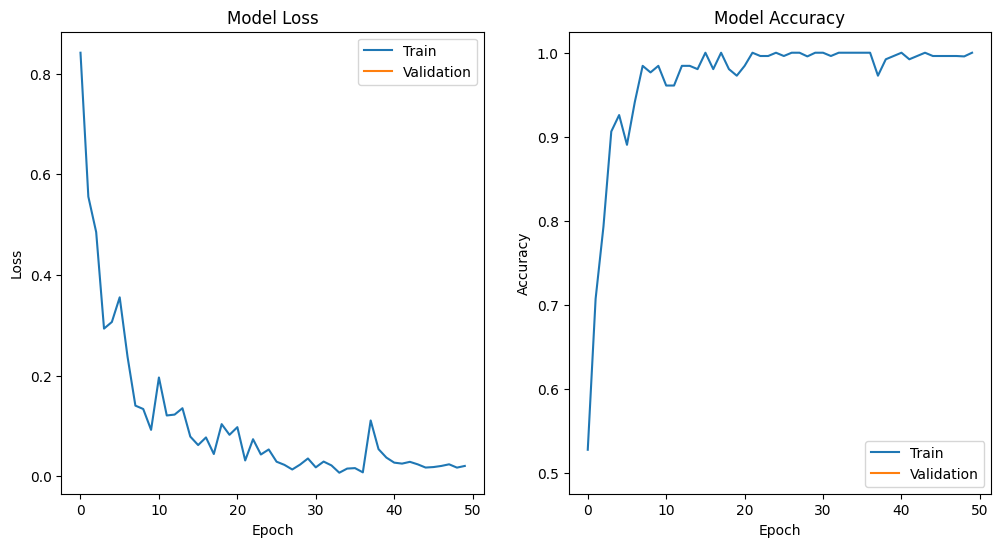

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Evaluation
#### Evaluate the trained network on the test data and report the Accuracy,Precision, Specificity, Sensitivity and 1F score. Draw the confusion matrix

In [91]:
test_set_path = '/content/test_set/'
normal_images_path = '/content/Dataset/Normal/'
covid_images_path = '/content/Dataset/Covid/'

In [92]:
if os.path.exists(test_set_path):
    shutil.rmtree(test_set_path)
    print(f"{test_set_path} folder cleared")


/content/test_set/ folder cleared


In [93]:
os.makedirs(test_set_path, exist_ok=True)


In [94]:
normal_test_path = os.path.join(test_set_path, 'NORMAL')
os.makedirs(normal_test_path, exist_ok=True)
normal_images = os.listdir(normal_images_path)[:50]
for img in normal_images:
    img_path = os.path.join(normal_images_path, img)
    shutil.copy2(img_path, os.path.join(normal_test_path, img))


In [95]:
covid_test_path = os.path.join(test_set_path, 'COVID')
os.makedirs(covid_test_path, exist_ok=True)
covid_images = os.listdir(covid_images_path)[:50]
for img in covid_images:
    img_path = os.path.join(covid_images_path, img)
    shutil.copy2(img_path, os.path.join(covid_test_path, img))

In [96]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_set_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 100 images belonging to 2 classes.


<ipython-input-97-61cab6f7f816>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


Confusion Matrix:
[[43  7]
 [39 11]]

Classification Report:
              precision    recall  f1-score   support

       COVID       0.52      0.86      0.65        50
      NORMAL       0.61      0.22      0.32        50

    accuracy                           0.54       100
   macro avg       0.57      0.54      0.49       100
weighted avg       0.57      0.54      0.49       100

Accuracy: 0.5400
Precision (NORMAL): 0.6111
Recall / Sensitivity(NORMAL): 0.2200
F1 Score (NORMAL): 0.3235
Specificity (NORMAL): 0.8600


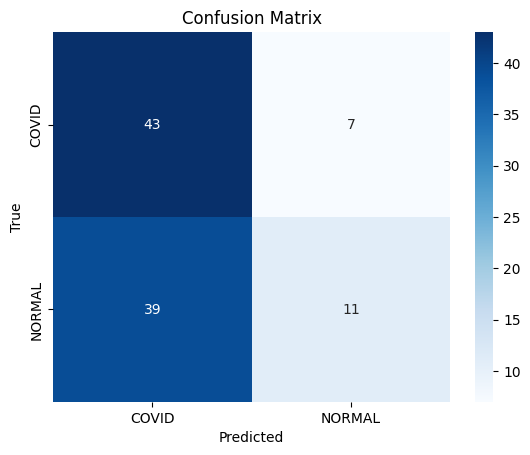

In [97]:
y_pred = model.predict_generator(test_generator)

y_pred_binary = np.round(y_pred)

y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, y_pred_binary)

report = classification_report(y_true, y_pred_binary, target_names=test_generator.class_indices, output_dict=True)

precision_normal = report['NORMAL']['precision']
recall_normal = report['NORMAL']['recall']
f1_score_normal = report['NORMAL']['f1-score']
accuracy = report['accuracy']

specificity_normal = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])

print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=test_generator.class_indices))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (NORMAL): {precision_normal:.4f}")
print(f"Recall / Sensitivity(NORMAL): {recall_normal:.4f}")
print(f"F1 Score (NORMAL): {f1_score_normal:.4f}")
print(f"Specificity (NORMAL): {specificity_normal:.4f}")

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
